In [55]:
%matplotlib inline

In [56]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from scipy import misc
import time
import os

plt.ion()   # interactive mode

## data loaded
Train set:      Cancer: Non cancer:
Validation set: Cancer: Non cancer:
Batch size=3

In [57]:
data_transforms = {'train':transforms.ToTensor(),'val': transforms.ToTensor()}


In [58]:
data_dir = 'Cancer_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=3,shuffle=True, num_workers=5) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#use_gpu = torch.cuda.is_available()

## visualize a batch of data

<class 'torch.FloatTensor'>
torch.Size([3, 3, 200, 200])
<class 'torch.LongTensor'>


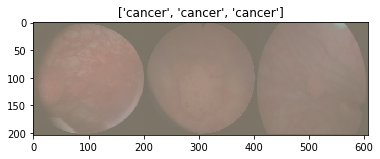

In [59]:
#in case of test error,modify here too!
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(type(inputs))
print(inputs.shape)
print(type(classes))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Get a batch of validation data
#inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
#out1 = torchvision.utils.make_grid(inputs1)

#imshow(out1, title=[class_names[x] for x in classes1])

## General function to train a model

In [97]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs, labels = Variable(inputs), Variable(labels)
                #if use_gpu:
                  #  inputs = Variable(inputs.cuda())
                   # labels = Variable(labels.cuda())
                #else:
                 #   inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    print('model weights')
    print(type(best_model_wts))
    print(best_model_wts)
    return model

## Generic function to display predictions for a few images

In [98]:
def visualize_model(model, img_location):
    #images_so_far = 0
    im=misc.imread(img_location)
    plt.imshow(im)
    input_image=torch.from_numpy(im)
    
    ####try reshaping image here to tensor, use numpy reshape function probabaly or just toTensor function#######
    
    
    fig = plt.figure()
    input_image = Variable(input_image)
    #if use_gpu:
     #       input_image = Variable(input_image.cuda())
    #else:
       # input_image = Variable(input_image)
    outputs=model(input_image.unsqueeze(0).float)
    _,preds = torch.max(outputs.data,1)
    
    print(preds)

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        #if use_gpu:
         #   inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #else:
         #   inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

# Finetuning the convnet

## Load a pretrained model and reset final fully connected layer.


In [99]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(type(model_ft))
print(model_ft)
print('hello')
print(num_ftrs)

#print(model_ft[:-1])
print('hello')
model_ft.fc = nn.Linear(num_ftrs, 2)

print(type(model_ft._modules.items()))

print('hello')

for (name, layer) in model_ft._modules.items():
    #iteration over outer layers
    print((name, layer))

#if use_gpu:
    #model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<class 'torchvision.models.resnet.ResNet'>
ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

# Train and evaluate

In [101]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0138 Acc: 0.9884
val Loss: 0.0257 Acc: 0.9632

Training complete in 2m 39s
Best val Acc: 0.963235
model weights
<class 'collections.OrderedDict'>
OrderedDict([('conv1.weight', 
(0 ,0 ,.,.) = 
 -3.5648e-03  8.5789e-03  1.2515e-02  ...   6.9808e-02  3.3651e-02  4.9676e-03
  1.5486e-02  1.9787e-02 -9.8346e-02  ...  -2.5934e-01 -1.1554e-01  1.8253e-02
 -5.0841e-03  6.6380e-02  3.0351e-01  ...   5.2803e-01  2.6601e-01  7.4892e-02
                 ...                   ⋱                   ...                
 -3.0863e-02  2.0795e-02  7.9208e-02  ...  -3.2861e-01 -4.1588e-01 -2.5285e-01
  2.8889e-02  4.5600e-02  6.8834e-02  ...   4.1812e-01  3.9849e-01  1.7054e-01
 -1.4159e-02  2.6494e-03 -1.7353e-02  ...  -1.4585e-01 -7.7326e-02 -5.7333e-04

(0 ,1 ,.,.) = 
 -2.8784e-05 -1.0776e-02 -1.9222e-02  ...   4.7439e-02  1.8000e-02 -7.4727e-03
  5.4492e-02  4.5696e-02 -9.1093e-02  ...  -2.9817e-01 -1.4506e-01  1.5095e-02
  5.7406e-03  1.0733e-01  4.1197e-01  ...   7.

AttributeError: 'function' object has no attribute 'dim'

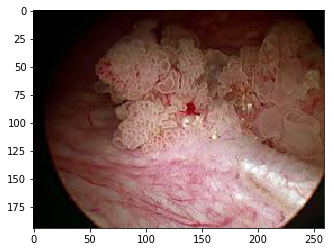

In [54]:
visualize_model(model_ft,'images.jpeg')

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()